# import seaborn as sns
sns.set_context('paper')

### Load Database

In [2]:
%run AH_DATABASE.ipynb


Usage: 
  db = DB(server)          --> initializes database
  db.get_df(item)          --> returns dataframe, prices divided by 100 so copper in decimal 
  db.get_name(item)        --> returns name of item  
  db.get_last_record(item) --> returns most recent record
  db.plot(item, y)         --> plots column over time



In [3]:
db = DB('earthfury-alliance')

### Flipping Analysis
Assume you purchase at a given percentile price 'buy_pctile' of an item and flip it for a 15% profit.  By examining how minBidprice fluctuates over time, determine how many times you could perform this flip 'num_flips'.  Calulate numFlips for values of P from 1 to 100.  Determine the optimal 'buy_pctile' that maximizes num_flips and look up the corresponding minBidPrice.

In [4]:
def num_flips_at_pctile(item, buy_pctile, profit=.15):
    df = db.get_df(item)
    count = 0
    buysell = 'buy'    
    
    for pct, val in df[['minBuyoutPctile','minBuyout']].to_numpy(): #apparently way faster than df.iterrows()
        # buy conditions
        if buysell=='buy' and pct < buy_pctile:
            price   = val
            buysell = 'sell'        
        # sell conditions
        if buysell=='sell' and val > price*(1+profit):
            count += 1
            buysell = 'buy'    
    return count

def num_flips_over_all_pctiles(item):
    return [ (i/100, num_flips_at_pctile(item,i/100)) for i in range(0,100)]

def get_minBuyout_at_pctile(item, pctile):
    arr = db.get_df(item)['minBuyout'].to_list()
    return np.percentile(arr, pctile*100)

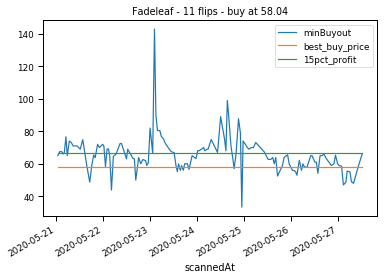

In [5]:
def find_optimal_flip(item, show_plot=False):
    flip_profile =  num_flips_over_all_pctiles(item)
    best_pctile, best_num_flips = max(flip_profile, key=lambda x:x[1])
    best_buy_price = get_minBuyout_at_pctile(item, best_pctile)
    
    if show_plot:
        df = db.get_df(item)
        df['best_buy_price'] = best_buy_price
        df['15pct_profit'] = best_buy_price * 1.15
        graph_title = f'{db.get_name(item)} - {best_num_flips} flips - buy at {round(best_buy_price,2)}'
        df.plot('scannedAt', ['minBuyout', 'best_buy_price', '15pct_profit'], title=graph_title)
    
    # return export ready data if not in plot mode
    else:
        return {
            'name'        : db.get_name(item),
            'item_id'     : item,
            'buy_price'   : int(100 * best_buy_price),         # scaling copper back into integer for export
            'min_price'   : int(100 * best_buy_price * 1.15),  # scaling copper back into integer for export
            'normal_price': int(100 * best_buy_price * 1.25),  # scaling copper back into integer for export
            'max_price'   : int(100 * best_buy_price * 1.5),   # scaling copper back into integer for export
            'num_flips'   : best_num_flips,
            'avg_quantity': int(db.get_df(item)['quantity'].mean())
        }

find_optimal_flip(3818, show_plot=True)        

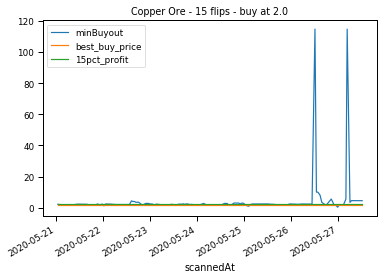

In [6]:
find_optimal_flip(2770, show_plot=True)

In [7]:
find_optimal_flip(2770, show_plot=False)

{'name': 'Copper Ore',
 'item_id': 2770,
 'buy_price': 200,
 'min_price': 229,
 'normal_price': 250,
 'max_price': 300,
 'num_flips': 15,
 'avg_quantity': 322}

### Run All Materials

In [8]:
%run ITEMS.ipynb


loaded
  herbs       : 30 items
  cloth       : 12 items
  mining      : 27 items
  enchant     : 24 items
  skinning    : 11 items
  meat        : 27 items
  consumables : 44 items
  bags        : 38 items
  eng         : 53 items
  ALL         : 266 items



In [9]:
enchant_no_shard = [i for i in enchant if 'Shard' not in db.get_name(i)]

In [10]:
for i in enchant_no_shard:
    print(db.get_name(i))

Strange Dust
Soul Dust
Vision Dust
Dream Dust
Illusion Dust
Lesser Magic Essence
Greater Magic Essence
Lesser Astral Essence
Greater Astral Essence
Lesser Mystic Essence
Greater Mystic Essence
Lesser Nether Essence
Greater Nether Essence
Lesser Eternal Essence
Greater Eternal Essence
Nexus Crystal


In [11]:
def run_analysis(list_of_items):
    results = []
    print(f'running for {len(list_of_items)} items')
    for i in range(0, len(list_of_items)):
        item = list_of_items[i]
        
        # catch no data errors with try/except
        try:
            results.append(find_optimal_flip(item))
        except: 
            print(f'! ERROR - {item}, {db.get_name(item)}')

        # print progress
        if i%10 ==0:
            print(f' ...{i} done')   
    print('COMPLETE')
    return pd.DataFrame(results)


list_of_items = herbs + mining + skinning + meat + eng + enchant_no_shard
df = run_analysis(list_of_items)    

running for 164 items
 ...0 done
 ...10 done
 ...20 done
 ...30 done
 ...40 done
 ...50 done
! ERROR - 17771, Elementium Bar
! ERROR - 3861, Blacksteel Bar
 ...60 done
 ...70 done
 ...80 done
! ERROR - 5467, Kodo Meat
 ...90 done
 ...100 done
 ...110 done
 ...120 done
 ...130 done
! ERROR - 4399, Wooden Stock
! ERROR - 4400, Heavy Stock
 ...140 done
 ...150 done
 ...160 done
! ERROR - 20725, Nexus Crystal
COMPLETE


In [12]:
df

,name,item_id,buy_price,min_price,normal_price,max_price,num_flips,avg_quantity
0,Wildvine,8153,11484,13206,14355,17226,10,80
1,Arthas' Tears,8836,484,557,606,727,10,105
2,Black Lotus,13468,1699998,1954997,2124997,2549997,2,19
3,Plaguebloom,13466,21127,24296,26409,31690,7,185
4,Mountain Silversage,13465,13000,14949,16250,19500,10,232
...,...,...,...,...,...,...,...,...
153,Greater Mystic Essence,11135,1800,2070,2250,2700,5,139
154,Lesser Nether Essence,11174,10348,11900,12935,15522,5,173
155,Greater Nether Essence,11175,30000,34500,37500,45000,3,53
156,Lesser Eternal Essence,16202,17782,20450,22228,26674,6,112


### Export

In [13]:
%run EXPORT.ipynb

 
Usage:
  EXPORT(dataframe) --> expects df with specific columns
                          name         - required, string
                          item_id      - required, integer
                          buy_price    - required, integer in copper
                          min_price    - required, integer in copper 
                          normal_price - required, integer in copper
                          max_price    - required, integer in copper
                          restock      - optional, default 20
  example_export_input()  --> shows expected data schema
  example_export_output() --> shows output of example data



In [14]:
def set_restock_value(item):
    if item in herbs + skinning:
        return 70
    if item in cloth + mining:
        return 70
    if item in bags:
        return 1
    if item in eng:
        return 15
    return 50

df['restock'] = df['item_id'].apply(set_restock_value)

In [28]:
choice = df.query('num_flips>=6 and num_flips<10 and min_price>250').sort_values(by='num_flips')
print(len(choice), 'rows')
choice.sort_values(by='name')

27 rows


,name,item_id,buy_price,min_price,normal_price,max_price,num_flips,avg_quantity,restock
135,Blue Sapphire,12361,60000,69000,75000,90000,6,13,15
90,Chunk of Boar Meat,769,333,382,416,499,9,59,50
77,Coyote Meat,2673,1345,1546,1681,2017,6,7,50
116,Elemental Air,7069,1500,1724,1875,2250,8,51,15
114,Elemental Earth,7067,30000,34500,37500,45000,7,115,15
125,Essence of Air,7082,169000,194349,211250,253500,6,36,15
5,Ghost Mushroom,8845,10000,11500,12500,15000,6,423,70
29,Golden Sansam,13464,317,364,396,475,8,180,70
151,Greater Astral Essence,11082,7739,8900,9674,11609,8,66,50
149,Greater Magic Essence,10939,1255,1443,1569,1883,9,62,50


In [29]:
EXPORT(choice)

^1^T^Soperations^T^SMailing^T^S#Default^T^Srestock^b^SkeepQty^N0^SmaxQtyEnabled^b^Starget^S^SrestockSources^T^Sguild^b^Sbank^b^t^SmaxQty^N10^t^t^SAuctioning^T^SLesser Eternal Essence^T^SaboveMax^SmaxPrice^SnormalPrice^S22228^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S26674^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S20450^SkeepQtySources^T^t^Sblacklist^S^t^SGhost Mushroom^T^SaboveMax^SmaxPrice^SnormalPrice^S12500^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S15000^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S11500^SkeepQtySources^T^t^Sblacklist^S^t^SIcecap^T^SaboveMax^SmaxPrice^SnormalPrice^S6248^Sduration^N3^Sma

In [32]:
choice = df.query('num_flips>=6 and min_price>250').sort_values(by='num_flips')
other = df.loc[~df['item_id'].isin(choice['item_id']) &
                df['item_id'].isin(mining+enchant)]
other

,name,item_id,buy_price,min_price,normal_price,max_price,num_flips,avg_quantity,restock
31,Incendicite Ore,3340,769,884,961,1153,2,35,70
34,Copper Ore,2770,200,229,250,300,15,322,70
35,Indurium Ore,5833,888,1021,1110,1332,2,16,70
41,Elementium Ore,18562,670000,770499,837500,1005000,3,7,70
42,Arcanite Bar,12360,733086,843048,916357,1099629,2,9,70
45,Steel Bar,3859,1899,2184,2374,2849,5,293,70
53,Dark Iron Bar,11371,59787,68755,74734,89681,3,45,70
54,Enchanted Thorium Bar,12655,15824,18198,19781,23737,3,32,70
150,Lesser Astral Essence,10998,2632,3026,3290,3948,4,30,50
153,Greater Mystic Essence,11135,1800,2070,2250,2700,5,139,50


In [33]:
EXPORT(other)

^1^T^Soperations^T^SMailing^T^S#Default^T^Srestock^b^SkeepQty^N0^SmaxQtyEnabled^b^Starget^S^SrestockSources^T^Sguild^b^Sbank^b^t^SmaxQty^N10^t^t^SAuctioning^T^SIncendicite Ore^T^SaboveMax^SmaxPrice^SnormalPrice^S961^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S1153^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S884^SkeepQtySources^T^t^Sblacklist^S^t^SCopper Ore^T^SaboveMax^SmaxPrice^SnormalPrice^S250^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S300^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S229^SkeepQtySources^T^t^Sblacklist^S^t^SIndurium Ore^T^SaboveMax^SmaxPrice^SnormalPrice^S1110^Sduration^N3^SmatchStackSize^b^S

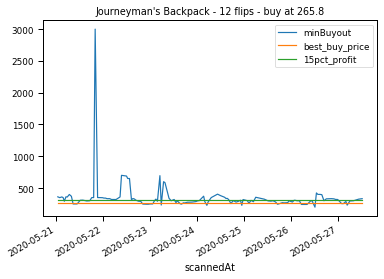

In [22]:
find_optimal_flip(3914, show_plot=True)

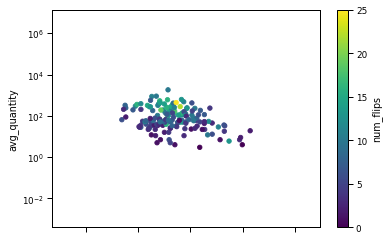

In [23]:
df.plot.scatter(x='min_price', y='avg_quantity', c='num_flips', colormap='viridis', logy=True, logx=True)